Name: Emily Inkrott
Class: CPSC 222, Fall 2020
Title: "Quantified Self: Physical and Digital Habits"

# Quantified Self: Technical Report

## Introduction

In my Quantified Self project, I chose to record and analyze my screen time and health data from my iPhone. My domain, therefore, is a cross between health and fitness and time management. Looking at the two data sets, I compared my screen time, recorded in minutes, based on the day of the week. Likewise, I explored the different metrics of physical activity relative to the day of the week. Based on this, I was able to see clear patterns in my different kinds of digital and physical activity following my weekly class schedule. 

My hypotheses were largely based on the data visualizations I put together. I hypothesized that Mondays would have a higher screen time level than other days of the week, since the physical activity for that weekday was the lowest. While the mean was the highest of all the weekdays, my hypothesis testing showed this to be innacurate. I also expected to see distinct patterns in activity for different class schedules: high screen time on Monday/Wednesday/Friday days, high flights climbed o Tuesday/Thursday days, and a higher distance traveled and step count on Saturday/Sunday days. Only one of these proved to be true through my hypothesis testing- the MWF screen time trend. I kept this in mind when conducting my classifications.

When working with classifications, I attempted to classify my data by he class schedules as grouped above. To improve my classifier, I adjusted the different data inputs, the number of neighbors, and the maximum depth of my decision tree.

In the end, my results showed that it is difficult to predict a day's class schedule based off of the screen time and health data, since this can fluctuate wildly depending on a number of circumstances. While these attributes might be correlated, it isn't enough to make a consistent prediction with a kNN classifier. However, there are trends in the data specific to certain days. With a longer time frame of collected data, and/or finding a way to take into account certain topics such as learning remotely/in person or major life changes that impacted my behavior, a more accurate classifier could probably be produced.


## Data Analysis
### Dataset Info and Preparation
The screen time data source was manually recorded in a csv file over the course of the semester, beginning in mid October. The "Screen Time" section of the iPhone's settings automatically records the amount of time users spend on their phones by day, and divides it into categories and apps so that users can see how much time they spend on their phone, and what they spend it on. The data can be viewed by day and by week, and is recorded in hours, minutes, and seconds (if less than a minute). In my manual recording of the data, I truncated any second counts and recorded the time for that category as a zero. In the screen_time.csv file, all times are recorded in minutes for ease of computation.

My second data source was my phone's health data, which is recorded via the health app. I was able to export the data from my phone as a csv file via the QS Access app. I cleaned the data during an earlier data assignment, changing the way that the dates were recorded for easy merging when it came time to combine the data from my two sources. I also sliced the data set so that the start and end dates for this source and the screen time data would line up. 

### Exploratory Data Analysis and Statistical Analysis
The attributes that I was most interested in exploring were the total screen time for each day, the total distance traveled, and the total flights climbed. I figured that these would be the best metrics of my physical and digital activity. In order to examine any trends in these attributes as they related to patterns in my week, I initially grouped the data by weekday, and visualized it using bar charts for easy comparison.

The following code was used to produce those bar charts. For more details on how exactly this was done, see AggregationAndHypoTesting.ipynb.

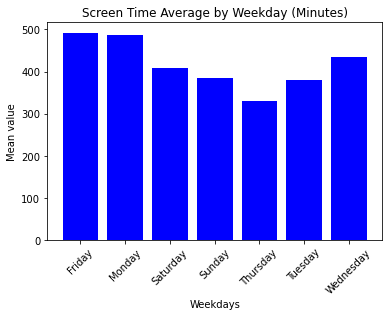

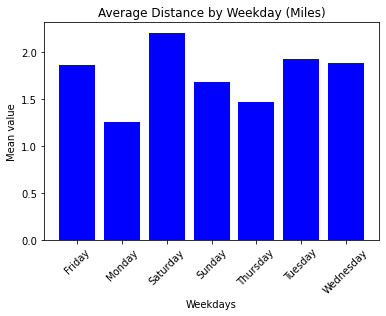

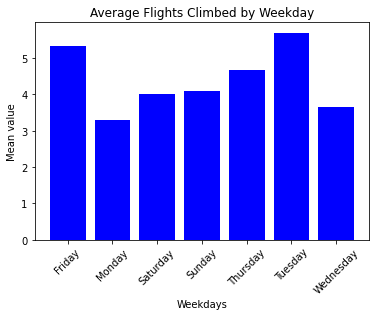

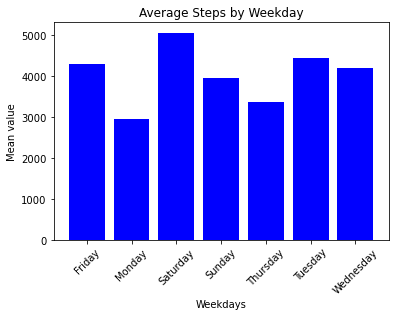

In [5]:
import pandas as pd
import numpy as np
import utils

health_df = pd.read_csv("health_data.csv")
health_df = health_df.dropna(axis=0)
screen_time_df = pd.read_csv("screen_time.csv")
screen_time_df = screen_time_df.dropna(axis=0)

health_weekday_groups = health_df.groupby("Weekday")
screen_time_weekday_groups = screen_time_df.groupby("Weekday")

distance_mean_ser = pd.Series(dtype=float)
flights_mean_ser = pd.Series(dtype=float)
steps_mean_ser = pd.Series(dtype=float)

for group_name, group_df in health_weekday_groups:
    distance_mean_ser[group_name] = group_df["Distance (mi)"].mean()
    flights_mean_ser[group_name] = group_df["Flights Climbed (count)"].mean()
    steps_mean_ser[group_name] = group_df["Steps (count)"].mean()
    
total_minutes_mean_ser = pd.Series(dtype=float)
for group_name, group_df in screen_time_weekday_groups:
    total_minutes_mean_ser[group_name] = group_df["Total Time (Minutes)"].mean()

utils.make_bar_chart(total_minutes_mean_ser, "Screen Time Average by Weekday (Minutes)")
utils.make_bar_chart(distance_mean_ser, "Average Distance by Weekday (Miles)")
utils.make_bar_chart(flights_mean_ser, "Average Flights Climbed by Weekday")
utils.make_bar_chart(steps_mean_ser, "Average Steps by Weekday")


Upon examining these visualizations, I was able to see some trends. For instance, Mondays, Wednesdays, and Fridays had the highest mean screen time usage. Those are days where my class schedule is the same, which indicates that a pattern emerges based on my class schedule. I also noticed that Mondays had the lowest level of physical activity across the board, but had a high amount of screen time. This lead me to hypothesize that lower physical activity would correlate to higher digital activity. Unfortunately, in conducting hypothesis tests, this was proven to be inaccurate. 

Following this, I aggregated my data based on my class schedule for the day. Looking at distances, flights, steps, and screen time minutes for the different schedule types, I was able to see that certain class days had higher screen time. However, physical activity did not prove to be a good metric for comparing schedule types. This helped to guide me in building my classifiers. For more details on the statistical analysis and hypothesis testing, see AggregationAndHypoTesting.ipynb.

## Classification Results

### Preprocessing

My preprocessing consisted of a few steps. First, I merged my two revised data frames together on the date, and then dropped the weekday and date columns. I chose not to include these in the classification, since the goal was to classify based off of screen time and health data. Including the day of the week would guarantee a correct classification of my schedule for the day, since the day of the week determines the day's schedule. Likewise, while the date was a useful key for joining the two data frames, it did not contribute any helpful information.

From here, I encoded nonnumerical attributes. Specifically, this refers to the "Highest" column, which describes the catgory of app that had the highest amount of screen time usage in the day. I used scikitlearn's label encoder to convert this to numerical data, allowing it to be used in classification.

After preparing the data frame, I implemented min-max scaling to keep any attributes from having too much "weight" in the classifier. The number of total minutes in a day was typically much larger than, say, the number of flights climbed. By choosing min-max scaling, the euclidean distance wouldn't be dominated by my screen time.

The following code was used to carry out these tasks. For more detail, see Classification.ipynb.

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#load data frames
health_df = pd.read_csv("revised_health.csv")
health_df = health_df.drop("Unnamed: 0", axis = 1)
screentime_df = pd.read_csv("revised_screen_time.csv")
screentime_df=screentime_df.drop("Unnamed: 0", axis = 1)
#drop duplicate columns
health_df = health_df.drop("Weekday", axis = 1)
health_df = health_df.drop("Schedule Type", axis = 1)
#merge
data_df = screentime_df.merge(health_df, on = "Date")
data_df = data_df.drop("Date", axis = 1)
data_df = data_df.drop("Weekday", axis = 1)

#encode labels
highest_le = LabelEncoder()
highest_le.fit(data_df["Highest"])
data_df["Highest"] = highest_le.transform(data_df["Highest"])

#define x and y
y = data_df["Schedule Type"]
x = data_df.drop("Schedule Type", axis=1)

#min-max scaling
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

From there, I used a kNN classifier with n=5 neighbors, and a decision tree classifier.

### Testing, Evaluation, and Revision

I made use of `sklearn`'s "train test split", which uses the hold out method to create a training and testing set from the provided data. My test set was stratified by different schedule types. I chose to evaluate the success of my classifiers by their accuracy. Unfortunately, I could not use regression, since class schedule is a nonnumeric attribute, and I could not use the presence of false negatives and false positives as a metric since the classification was not binary. The accuracy of my initial kNN classifier was about 53%. It was able to correctly classify Monday/Wednesday/Friday schedules, but failed at distinguishing Tuesday/Thursday and Saturday/Sunday schedules. Likewise, the decision tree classifier scored 59% accuracy, with a larger variation of which values were correctly or incorrectly classified.

Based on these results, I decided to revise the data frame. My hypotheis testing had shown that physical activity was not a successful metric in determining what schedule I had on a certain day. Because of this, I chose to run the classifier without the health metrics. I also chose to cut out certain categories of screen time data that rarely had significant data. Due to the min max scaling, a column that had 0 minutes of time recorded for every day but a select few could have more weight than it should. Min max scaling kept certain attributes from dominating the classifier's computations, but it gave more power to attributes that shouldn't have carried much weight. Therefore, those attributes were removed.

With this revised dataset, the kNN classifier did not improve. However, the revised decision tree improved significantly, climbing from 59% accuracy to 64%. From there, I chose to manipulate the number of neighbors taken into account by the kNN classifier. By increasing the number of neighbors from 5 to 13, I was able to increase the accuracy of my classifier to 65%, matching the decision tree for performance.

The last classifier I used for comparison was a decision tree with a max depth limited to 5. Given the same revised data set as the 64% accurate kNN classifier and decision tree, the limited depth tree was able to predict the class schedule of each instance with 100% accuracy. 

Compared to the decision tree, the kNN classifier was not as strong of an option. While manipulating the data and he number of neighbors was able to put the kNN classifier on even footing with the unlimited decision tree. However, by limiting the tree's depth, I was able to construct a classifier that was much more accurate than the kNN classifier. 

## Conclusion

The screen time and health data for this project proved to be very informative, though perhaps not in the way I expected. Going into this project, I expected to find a correlation between physical activity and screen time, and would have believed my weekend activity to be distinct from that of weekdays. However, analysis of this dataset has countered my expectations. 

That said, these data sets have their own issues. The limited time frame of the data only allows me to look at a portion of this semester, since screen time data only reaches back so far. Similarly, the health data only tracks so many attributes automatically, limiting the health data available to me for this project. With more data, we would probably find more trends to analyze. Furthermore, the data is somewhat inconsistent. Between the beginning of the time period of the end, my living situation changed, my technological situation changed, and my schedule changed from in person learning to break to remote learning. Not having any indication of these lifestyle changes present in the data keeps them from being properly taken into account by any classifiers.

The kNN classifier was able to make some predictions based off of the data provided, but its accuracy was low, likely due to a large amount of variation in the data. The decision tree classifier did a much better job of classifying the daya, especially once its depth was limited. To improve the performance of the kNN classifier, I would add another attribute to the data frame that states whether that day was part of in person learning, remote learning, or Thanksgiving Break. by distinguishing between these different time periods, we might be able to see a higher accuracy.

This project has shown that there are definite ways to connect a person's habits with their digital and physical activity, though it could likely be done more accurately over a less volatile time period. Methods such of this could probably be useful in advertising and app development, allowing developers and advertisers to tailor a person's experience to whatever their specific schedule might look like. One example of this is the iPhone's "widgets", which can suggest different apps from the home screen. By taking into account a person's habits and determining a weekly schedule, better suggestions can be given.

However, this also proposes a threat to individual privacy. If physical and digital activity is enough to classify a schedule, even over a two month time period with inconsistent data, privacy becomes harder and harder to protect. This data is absolutely available to those with commercial interests; Apple collected all of the data used in this project, and can access it much more readily than I could. This data can be incredibly useful, but it can also be used to learn things about subjects without them explicitly giving that information away. 